# Статистико-комбинаторная модель морфологии

Данный подход моделирования языка был описан Н.Д. Андреевым. ("Статистико-комбинаторный методы в теоретическом и прикладном языковедении", М., 1967) Эксперименты по применению статистико-комбинаторной модели были проведены для различных корпусов языков, в том числе английского, французского и русского.
Статистико-комбинаторное моделирование языка можно описать двумя этапами:

1)	опираясь на статистику и комбинаторику, при этом не обращаясь к критерию правильности грамматики, сформировать систему языковых форм

2)	затем, учитывая смысл текста, установить значения полученных форм и выявить правильность грамматики.

Работы Андреева были найдены, ореферированы и реализованы в виде программы на Питоне (*Unsupervised learning of morphology in the USSR*, Franck Burlot, François Yvon, 2016)

Мы пытаемся реализовать данный алгоритм для якутского языка

### Считываем частоты слов

In [4]:
# Загрузить словарь количеств из файла.
# Словарь содержит частоты слов в виде {слово: число вхождений в корпус, ... }, 
# например {"көппөҕү" : 4, "хазар" : 3, ...}
#
# корпус в формате txt  занимет 174 МБ, словарь частот в json 10,4МБ, 
# после сжатия в формат .bz2 1,7 МБ
import bz2, json
jsondict = bz2.open('voc.json.bz2', 'r').read().decode(encoding='utf-8')
voc = json.loads(jsondict)
del jsondict
words=list(voc.keys())

In [ ]:
word_count = sum([voc[k] for k in voc])
"Загружено {} словоформ, {:.1f} млн словоупотреблений".format(len(voc), word_count/1000000.0)

'Загружено 386233 словоформ, 11.9 млн словоупотреблений'

## Константы-параметры алгоритма

In [67]:
WORD_LEN_COEFF = 1
THRESHOLD_COEFF = 0.5
AFFIX_LEN = 1

### Вычисляем частоту появления каждой буквы в тексте и общее количество букв в тексте

In [6]:
from collections import defaultdict
prob = defaultdict(lambda: 0)
for word in voc:
    for char in word:
        prob[char]+=voc[word]
total = sum([n for n in prob.values()])#84263863
prob, total

(defaultdict(<function __main__.<lambda>>,
             {'а': 11101459,
              'б': 2901561,
              'в': 427404,
              'г': 1311975,
              'д': 1900403,
              'е': 778639,
              'ж': 37901,
              'з': 91125,
              'и': 5474794,
              'й': 1316593,
              'к': 2871767,
              'л': 4443816,
              'м': 1332271,
              'н': 6053266,
              'о': 4046042,
              'п': 914556,
              'р': 5889206,
              'с': 3247664,
              'т': 6289053,
              'у': 4051425,
              'ф': 88899,
              'х': 1971611,
              'ц': 98852,
              'ч': 637310,
              'ш': 34279,
              'щ': 13392,
              'ъ': 6759,
              'ы': 4767439,
              'ь': 679475,
              'э': 5704321,
              'ю': 29007,
              'я': 166433,
              'ё': 1635,
              'ҕ': 800062,
              'ҥ': 490070,
    

### независимые вероятности букв  - вероятность букв, независимая от их расположения по позициям в слове

In [7]:
for k,v in prob.items():
    prob[k] = v/total
prob

defaultdict(<function __main__.<lambda>>,
            {'а': 0.13174638100795355,
             'б': 0.034434227160936116,
             'в': 0.0050722098985658895,
             'г': 0.015569841605766402,
             'д': 0.02255300116017705,
             'е': 0.009240485449854108,
             'ж': 0.00044978949042485743,
             'з': 0.0010814244298294276,
             'и': 0.06497202721408583,
             'й': 0.015624645644361213,
             'к': 0.034080647358880285,
             'л': 0.052736912856701096,
             'м': 0.01581070404996742,
             'н': 0.07183703410321932,
             'о': 0.04801633649290444,
             'п': 0.010853478198596236,
             'р': 0.06989005476760542,
             'с': 0.038541598787133695,
             'т': 0.07463523242460413,
             'у': 0.048080219156342266,
             'ф': 0.0010550074116587795,
             'х': 0.02339806092203487,
             'ц': 0.001173124474485581,
             'ч': 0.007563265880653964,
  

### выведем график частот букв по корпусу языка

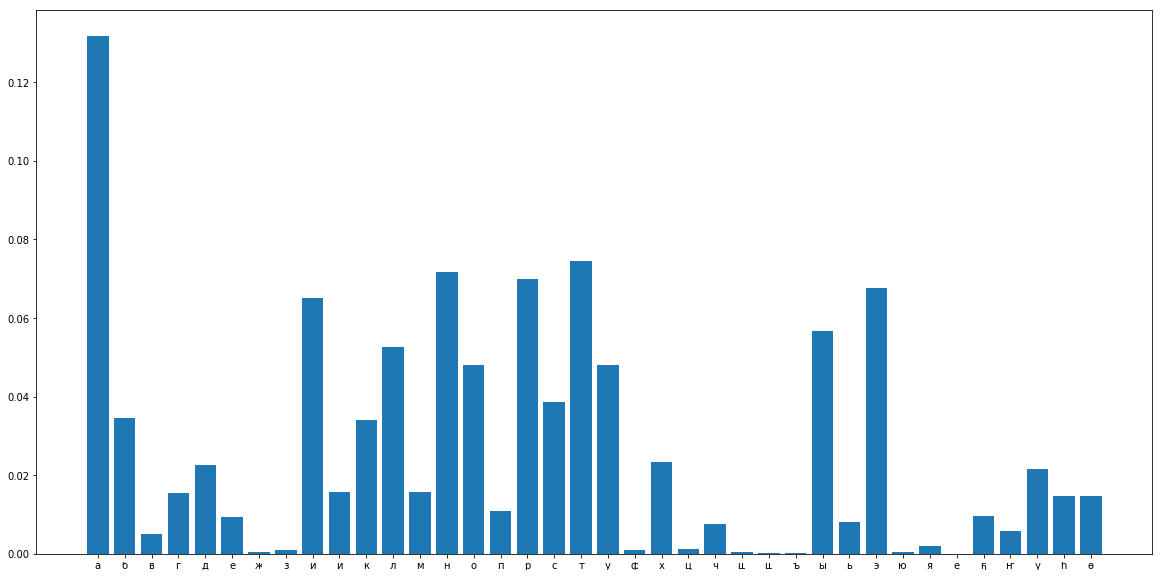

In [35]:
%matplotlib inline

from matplotlib import pyplot as plt
import numpy as np
letters = list(prob.keys())
letters.sort()
ind = range(0,len(letters))

plt.figure(figsize=(20,10))
plt.bar(ind, [prob[l] for l in letters], tick_label=letters)
plt.show()

### вычислим среднюю длину слова

In [39]:
words=list(voc.keys())
len_word = sum([len(w)*voc[w] for w in words]) / word_count  #average word length
len_word

7.1053179762290535

### подсчитываем условные вероятности букв в зависимости от позиции с конца слова

In [61]:
len_search = int(len_word * WORD_LEN_COEFF)
cond_prob = defaultdict(lambda: 0)
total = defaultdict(lambda: 0)

for word in voc:#для слова в словаре   
    positions = range(-min(len_search, len(word) - 2), 0) # from -7 to 0
    for i in positions: 
        cond_prob[(i, word[i])] += voc[word]
        total[i] += voc[word] # dictionary with prob of char words?
cond_prob

defaultdict(<function __main__.<lambda>>,
            {(-7, 'а'): 383428,
             (-7, 'б'): 113007,
             (-7, 'в'): 12206,
             (-7, 'г'): 43716,
             (-7, 'д'): 91499,
             (-7, 'е'): 60213,
             (-7, 'ж'): 3322,
             (-7, 'з'): 9444,
             (-7, 'и'): 222801,
             (-7, 'й'): 56987,
             (-7, 'к'): 81627,
             (-7, 'л'): 322366,
             (-7, 'м'): 70082,
             (-7, 'н'): 167013,
             (-7, 'о'): 178162,
             (-7, 'п'): 83118,
             (-7, 'р'): 269661,
             (-7, 'с'): 114536,
             (-7, 'т'): 276252,
             (-7, 'у'): 171909,
             (-7, 'ф'): 3045,
             (-7, 'х'): 53856,
             (-7, 'ц'): 11773,
             (-7, 'ч'): 43165,
             (-7, 'ш'): 3514,
             (-7, 'щ'): 880,
             (-7, 'ъ'): 954,
             (-7, 'ы'): 192994,
             (-7, 'ь'): 29509,
             (-7, 'э'): 188870,
             (-7, 'ю'): 

In [62]:
for posChar in cond_prob: #получаем из частот вероятности
    i = posChar[0]
    cond_prob[posChar] /= total[i]
cond_prob

defaultdict(<function __main__.<lambda>>,
            {(-7, 'а'): 0.10984867258690777,
             (-7, 'б'): 0.03237548886108653,
             (-7, 'в'): 0.0034969091918060136,
             (-7, 'г'): 0.012524240720055028,
             (-7, 'д'): 0.026213640352372475,
             (-7, 'е'): 0.017250482808964074,
             (-7, 'ж'): 0.0009517231144666211,
             (-7, 'з'): 0.00270562103944093,
             (-7, 'и'): 0.06383048212711548,
             (-7, 'й'): 0.016326262830857717,
             (-7, 'к'): 0.02338540116332537,
             (-7, 'л'): 0.09235495891575761,
             (-7, 'м'): 0.02007786252499992,
             (-7, 'н'): 0.04784772200975731,
             (-7, 'о'): 0.05104181021059667,
             (-7, 'п'): 0.023812559249920713,
             (-7, 'р'): 0.07725545056296915,
             (-7, 'с'): 0.03281353360582448,
             (-7, 'т'): 0.0791437127687035,
             (-7, 'у'): 0.04925038196413075,
             (-7, 'ф'): 0.0008723651064271106,
   

In [47]:
# проверяем что сумма вероятностей в каждой позиции равна 1
prob_sum = [0]*int(len_word)
for k, v in cond_prob.items():
    prob_sum[-k[0]-1] += v
prob_sum

[1.0000000000000004,
 1.0000000000000002,
 1.0000000000000002,
 0.9999999999999999,
 1.0000000000000002,
 1.0000000000000002,
 1.0]

### вычисление коррелятивной функции
для каждой позиции `i` ищем букву с наибольшим значением `maxlet[i]` условной вероятности, половина УВ данной буквы считается за **порог** `thres_cond[i]` медиального разбиения этой позиции


In [68]:
thres_cond = defaultdict(lambda: 0.0)
maxlet = ['']*8 
#для каждой позиции ищем букву с наибольшим значением условной вероятности, 
#половина УВ данной буквы считается за порог медиального разбиения
for posChar in cond_prob:#цикл по позициям букв в условной вероятности
    i = posChar[0]
    if cond_prob[posChar] > thres_cond[i]:
        thres_cond[i] = cond_prob[posChar]
        maxlet[-i] = posChar[1]
for pos in thres_cond:
            thres_cond[pos] *= THRESHOLD_COEFF
thres_cond, maxlet #порог медиального разбиения - половина условной вероятности , буквы с УВ не меньше порога - верхнее подмножество

(defaultdict(<function __main__.<lambda>>,
             {-7: 0.05492433629345388,
              -6: 0.06862642274278133,
              -5: 0.054922303965662854,
              -4: 0.06650096963057107,
              -3: 0.05873085296518737,
              -2: 0.10592977843602476,
              -1: 0.11335678492291414}),
 ['', 'н', 'а', 'т', 'а', 'т', 'а', 'а'])

буквы, условная вероятность которых превышает порог медиального разбиения в данной позиции, образуют **верхнее подмножество** этой позиции cond_prob_sup

In [69]:
cond_prob_sup = {}
for posChar in cond_prob:
        i = posChar[0]
        if cond_prob[posChar] > thres_cond[i]:
            cond_prob_sup[posChar] = cond_prob[posChar]
cond_prob_sup # верхнее подмножество

{(-7, 'а'): 0.10984867258690777,
 (-7, 'и'): 0.06383048212711548,
 (-7, 'л'): 0.09235495891575761,
 (-7, 'р'): 0.07725545056296915,
 (-7, 'т'): 0.0791437127687035,
 (-7, 'ы'): 0.055291044778257394,
 (-6, 'а'): 0.13725284548556266,
 (-6, 'л'): 0.0845904659839493,
 (-6, 'р'): 0.06971272773577977,
 (-6, 'т'): 0.07240338252534236,
 (-6, 'э'): 0.06970933766753558,
 (-5, 'а'): 0.10291636935565768,
 (-5, 'и'): 0.05814508606814193,
 (-5, 'л'): 0.10278631409655213,
 (-5, 'н'): 0.058502977690250556,
 (-5, 'р'): 0.0832513431321077,
 (-5, 'т'): 0.10984460793132571,
 (-4, 'а'): 0.13300193926114215,
 (-4, 'и'): 0.08205006877649267,
 (-4, 'л'): 0.09036931414181158,
 (-4, 'т'): 0.09283264131703954,
 (-4, 'ы'): 0.08336871533674335,
 (-4, 'э'): 0.07012689693346759,
 (-3, 'а'): 0.10697418939386719,
 (-3, 'л'): 0.07317219182980599,
 (-3, 'н'): 0.10141220408981981,
 (-3, 'р'): 0.09285611093898877,
 (-3, 'т'): 0.11746170593037474,
 (-2, 'а'): 0.21185955687204952,
 (-2, 'э'): 0.11733017290969582,
 (-1, 'а'):

In [52]:
# для сравнения-безусловные вероятности
{l: prob[l] for l in ['а','н','ы','р','и','т']}

{'а': 0.13174638100795355,
 'и': 0.06497202721408583,
 'н': 0.07183703410321932,
 'р': 0.06989005476760542,
 'т': 0.07463523242460413,
 'ы': 0.05657750345483212}

**коррелятивная функция** -  отношение условной вероятности к независимой, для каждой буквы верхнего подмножества и позиция

In [70]:
cf = {}
for posChar in cond_prob_sup:
    char = posChar[1]
    cf[posChar] = cond_prob_sup[posChar] / prob[char]
cf

{(-7, 'а'): 0.8337889188794961,
 (-7, 'и'): 0.982430206722519,
 (-7, 'л'): 1.751239386475054,
 (-7, 'р'): 1.1053854632086746,
 (-7, 'т'): 1.060406864126186,
 (-7, 'ы'): 0.9772620105515658,
 (-6, 'а'): 1.041795944871356,
 (-6, 'л'): 1.604008680102341,
 (-6, 'р'): 0.9974627716001184,
 (-6, 'т'): 0.9700965639583642,
 (-6, 'э'): 1.0297418534191813,
 (-5, 'а'): 0.7811703711955822,
 (-5, 'и'): 0.8949249170962633,
 (-5, 'л'): 1.94903926924671,
 (-5, 'н'): 0.8143846474255929,
 (-5, 'р'): 1.1911758176314287,
 (-5, 'т'): 1.4717527414721967,
 (-4, 'а'): 1.00953011569337,
 (-4, 'и'): 1.2628522195580245,
 (-4, 'л'): 1.7135874901772652,
 (-4, 'т'): 1.2438179436343055,
 (-4, 'ы'): 1.4735311784002565,
 (-4, 'э'): 1.0359100120446996,
 (-3, 'а'): 0.8119706103153539,
 (-3, 'л'): 1.3874947900085177,
 (-3, 'н'): 1.4116980935502612,
 (-3, 'р'): 1.328602635206809,
 (-3, 'т'): 1.573810412515745,
 (-2, 'а'): 1.6080863493264344,
 (-2, 'э'): 1.7331937693949762,
 (-1, 'а'): 1.1594868139451946,
 (-1, 'н'): 3.15594

### определение информантов

In [76]:
import operator, math

In [74]:
informants = {}
for pos in range(-len_search, 0):
    kmax = max({k for k in cf if k[0]==pos}, key=lambda k: cf[k])
    informants[pos] = (kmax[1], cf[kmax])
            
informants

{-7: ('л', 1.751239386475054),
 -6: ('л', 1.604008680102341),
 -5: ('л', 1.94903926924671),
 -4: ('л', 1.7135874901772652),
 -3: ('т', 1.573810412515745),
 -2: ('э', 1.7331937693949762),
 -1: ('н', 3.15594279017803)}

In [26]:
from collections import Counter
freq = [(word[-2], n) for word, n in voc.items() if len(word)>1 and word[-1]=='н']#частота буквы в -2 позиции перед буквой "н"
cond_prob_let = defaultdict(int) #словарь условных вероятностей символов
for let, n in freq:
    cond_prob_let[let] += n
cond_prob_let = sorted(cond_prob_let.items(), key=operator.itemgetter(1), reverse=True)#сортируем элементы словаря по вероятностям в убыв порядке
cond_prob_let

[('а', 798469),
 ('э', 500106),
 ('ы', 462367),
 ('и', 376365),
 ('о', 192704),
 ('у', 127619),
 ('ү', 92134),
 ('ө', 42450),
 ('е', 5962),
 ('я', 925),
 ('й', 386),
 ('н', 121),
 ('р', 117),
 ('л', 109),
 ('ю', 40),
 ('т', 40),
 ('ё', 38),
 ('ш', 25),
 ('м', 22),
 ('ь', 17),
 ('б', 13),
 ('г', 6),
 ('к', 4),
 ('ц', 3),
 ('х', 3),
 ('п', 2),
 ('с', 2),
 ('в', 2),
 ('ж', 1),
 ('ҥ', 1),
 ('ҕ', 1),
 ('д', 1),
 ('һ', 1)]

сумма 

In [27]:
[sum([x[1] for x in cond_prob_let[:i]])/sum([x[1] for x in cond_prob_let[i:2*i]]) for i in range(1,len(cond_prob_let)//2)]#201217

[1.5965995209015689,
 1.5482597540096241,
 2.5275905426819465,
 4.6983383416830256,
 8.65885391504701,
 17.309935342095255,
 50.92398641901338,
 336.65116883116883,
 1442.6296501943366,
 2840.5475409836067,
 4743.589416058394,
 5989.880184331797,
 8073.680124223602,
 11980.801843317973,
 14524.435754189944]

In [84]:
print([x[1] for x in cond_prob_let[:i]])

[798469, 500106, 462367, 376365, 192704, 127619, 92134, 42450, 5962, 925, 386, 121, 117, 109, 40, 40, 38, 25, 22, 17, 13, 6, 4, 3, 3, 2, 2, 2, 1, 1, 1]


In [ ]:
print([x[1] for x in cond_prob_let[i:2*i]])

In [ ]:
print(3)